In [1]:
import json
import os
import time
import warnings

import gc

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import pybedtools
import csv
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2025-04-10 16:04:40.182534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 16:04:40.182750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 16:04:40.542867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 16:04:41.090578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 16:04:56.355311: W tensorflow/compiler/tf2

In [ ]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_rna3_only.txt' #Subset of targets_human.txt

seq_len = 524288
n_reps = 4       #To use only one model replicate, set to 'n_reps = 1'. To use all four replicates, set 'n_reps = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Remove cropping
params_model['trunk'][-1]['cropping'] = 0

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for rep_ix in range(n_reps) :
    
    model_file = "saved_models/f3c" + str(rep_ix) + "/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


In [5]:
#Load genome fasta and gene annotations

#Initialize fasta sequence extractor
fasta_open = pysam.Fastafile('hg38/assembly/ucsc/hg38.fa')

#Load gene/exon annotation
gtf_file = 'hg38/genes/gencode41/gencode41_basic_nort.gtf'

transcriptome = bgene.Transcriptome(gtf_file)

#Get gene span bedtool
bedt_span = transcriptome.bedtool_span()

#Load APA atlas
#apa_df = pd.read_csv('hg38/genes/polyadb/polyadb_human_v3.csv.gz', sep='\t', compression='gzip')
#apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_type', 'pas_type', 'total_count']]

apa_df = pd.read_csv('/home/jlinder/seqnn/data/apa/polyadb_human_v3_utr3_filtered_max_var.csv.gz', sep='\t', compression='gzip')
apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_num_kept', 'site_type', 'pas_type', 'total_count', 'gtex_blood_pred']]

apa_df = apa_df.loc[(~apa_df['gtex_blood_pred'].isnull())].copy().reset_index(drop=True)
apa_df = apa_df.sort_values(by=['chrom', 'gene', 'site_num_kept'], ascending=True).copy().reset_index(drop=True)

apa_df.loc[apa_df['pas_type'] == 'NoPAS', 'pas_type'] = 'No_CSE'

#Only consider 3' UTR sites
apa_df_utr = apa_df.query("site_type == '3\\' most exon'").copy().reset_index(drop=True)

#Or intronic sites
apa_df_intron = apa_df.query("site_type == 'Intron' and pas_type != 'No_CSE'").copy().reset_index(drop=True)

print("len(apa_df_utr) = " + str(len(apa_df_utr)))
print("len(apa_df_intron) = " + str(len(apa_df_intron)))

#Load TSS atlas
tss_df = pd.read_csv('hg38/genes/gencode41/gencode41_basic_tss2.bed', sep='\t', names=['chrom', 'position_hg38', 'end', 'tss_id', 'feat1', 'strand'])
tss_df['gene'] = tss_df['tss_id'].apply(lambda x: x.split("/")[1] if "/" in x else x)

print("len(tss_df) = " + str(len(tss_df)))


len(apa_df_utr) = 42428
len(apa_df_intron) = 0
len(tss_df) = 116649


In [6]:
#Get stranded targets

def targets_prep_strand(targets_df) :
    
    #Attach strand
    targets_strand = []
    for _, target in targets_df.iterrows() :
        if target.strand_pair == target.name :
            targets_strand.append('.')
        else :
            targets_strand.append(target.identifier[-1])
    targets_df['strand'] = targets_strand

    #Collapse stranded
    strand_mask = (targets_df.strand != '-')
    targets_strand_df = targets_df[strand_mask]

    return targets_strand_df

targets_strand_df = targets_prep_strand(targets_df)


In [7]:
#Get reference sequence and annotations for target gene

search_gene = 'ENSG00000064300'

chrom = 'chr17'
start = 49249074
end = 49773362

load_isoforms = True

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]
gene_strand = gene.strand

g_start, g_end = gene.span()
gene_width = (g_end - g_start)

#Calculate optimal plot width
plot_width = 0
if gene_width * 1.25 <= 4096 :
    plot_width = 4096
elif gene_width * 1.25 <= 8192 :
    plot_width = 8192
elif gene_width * 1.25 <= 16384 :
    plot_width = 16384
elif gene_width * 1.25 <= 2*16384 :
    plot_width = 2*16384
elif gene_width * 1.25 <= 4*16384 :
    plot_width = 4*16384
elif gene_width * 1.25 <= 6*16384 :
    plot_width = 6*16384
elif gene_width * 1.25 <= 8*16384 :
    plot_width = 8*16384
elif gene_width * 1.25 <= 12*16384 :
    plot_width = 12*16384
else :
    plot_width = 524288

if chrom is None or start is None or end is None :
    chrom = gene.chrom
    mid = (g_start + g_end) // 2
    start = mid - 524288 // 2
    end = mid + 524288 // 2

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True)

#Get sequence bedtool
seq_bedt = pybedtools.BedTool('%s %d %d' % (chrom, start, end), from_string=True)

#Get all genes (exons and strands) overlapping input window
gene_ids = sorted(list(set([overlap[3] for overlap in bedt_span.intersect(seq_bedt, wo=True) if search_gene not in overlap[3]])))
gene_slices = []
gene_strands = []
for gene_id in gene_ids :
    gene_slices.append(transcriptome.genes[gene_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))
    gene_strands.append(transcriptome.genes[gene_id].strand)

#Get 3' UTR pA sites for gene
apa_df_gene_utr = apa_df_utr.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]
apa_df_gene_intron = apa_df_intron.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

#Get TSS sites for gene
tss_df_gene = tss_df.loc[tss_df['gene'].str.contains(search_gene)].copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

def _switch_transcript_id(id_str) :
    return id_str.replace("gene_id", "gene_id_orig").replace("transcript_id", "gene_id")

#Get gene isoforms
isoform_slices = None
if load_isoforms :
    gtf_df = pd.read_csv(gtf_file, sep='\t', skiprows=5, names=['chrom', 'havana_str', 'feature', 'start', 'end', 'feat1', 'strand', 'feat2', 'id_str'])
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains(search_gene)].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains("transcript_id")].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['feature'] == 'exon'].copy().reset_index(drop=True)
    
    transcript_ids = gtf_df['id_str'].apply(lambda x: x.split("transcript_id \"")[1].split("\";")[0]).unique().tolist()
    gtf_df['id_str'] = gtf_df['id_str'].apply(_switch_transcript_id)
    
    gtf_df.to_csv('borzoi_gene_isoforms.gtf', sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE)
    
    transcriptome_iso = bgene.Transcriptome('borzoi_gene_isoforms.gtf')
    
    isoform_slices = []
    for transcript_id in transcript_ids :
        isoform_slices.append(transcriptome_iso.genes[transcript_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))


In [8]:
%%time
#Predict

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)


2025-04-10 16:07:53.193867: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-04-10 16:07:54.925031: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-10 16:07:56.865475: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-10 16:07:58.246316: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-10 16:07:58.475243: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

CPU times: user 25 s, sys: 1.29 s, total: 26.3 s
Wall time: 37.4 s


In [9]:
#Load gradient tracks (and add some gaussian smoothing)

from scipy.ndimage import gaussian_filter1d
import h5py

import gc

borzoi_grad_dir = '/scratch4/jlinder/seqnn/gradients/linnar_brain'

gtex_tissues = [
    'linnar_brain_medium_spiny_neuron_1_and_2_smooth',
    'linnar_brain_microglia_1_and_2_smooth',
    'linnar_brain_oligodendrocyte_1_and_2_smooth',
]

all_scores = []
for gtex_tissue in gtex_tissues :
    
    print("tissue = '" + gtex_tissue + "'")

    score_file = h5py.File('%s/%s/scores_mean.h5' % (borzoi_grad_dir, gtex_tissue), 'r')

    score_genes = [gene_name.decode('UTF-8') for gene_name in score_file['gene']]
    score_genes = [gene_id.split(".")[0] for gene_id in score_genes]

    for gi in range(len(score_genes)) :
        
        if score_genes[gi] == search_gene :
            
            #Get scores and onehots
            scores = score_file['grads'][gi][..., 0].astype('float32')
            seqs = score_file['seqs'][gi].astype('float32')

            #Get gated, smoothed, absolute-valued gradient scores
            scores = np.abs(np.sum((scores * seqs)[None, ...], axis=-1))
            scores = gaussian_filter1d(scores, sigma=200)
            
            #Append input-gated scores
            all_scores.append(scores)

    #Close file
    score_file.close()
    
    #Collect garbage
    gc.collect()

score_file = None

#Collect final scores
pred_grad_wt = np.concatenate(all_scores, axis=0)

print("pred_grad_wt.shape = " + str(pred_grad_wt.shape))


tissue = 'linnar_brain_medium_spiny_neuron_1_and_2_smooth'
tissue = 'linnar_brain_microglia_1_and_2_smooth'
tissue = 'linnar_brain_oligodendrocyte_1_and_2_smooth'
pred_grad_wt.shape = (3, 524288)


In [10]:
#Mask cropped prediction with zeros
zero_pad = 10240

if zero_pad > 0 :
    mask_mat = np.zeros(y_wt.shape, dtype=y_wt.dtype)
    mask_mat[:, :, zero_pad:-zero_pad, :] = 1.
    
    y_wt *= mask_mat


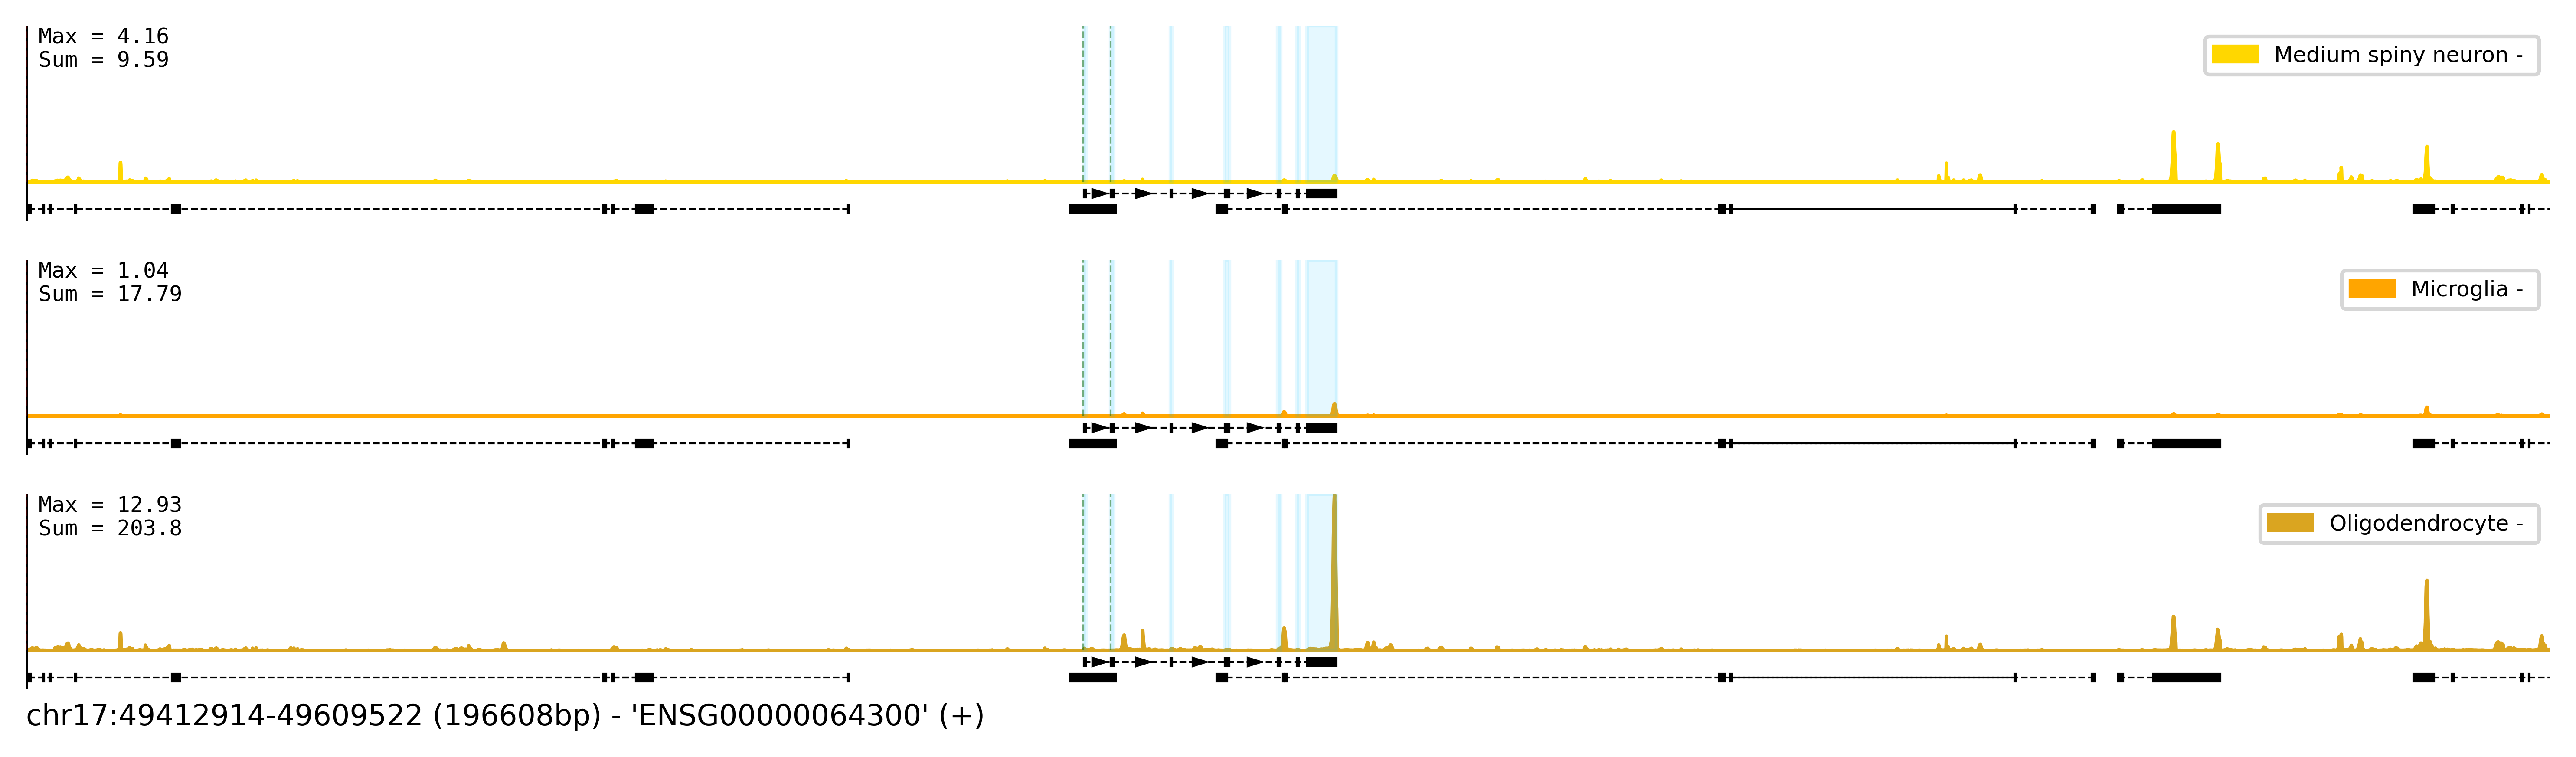

--- Measured ---


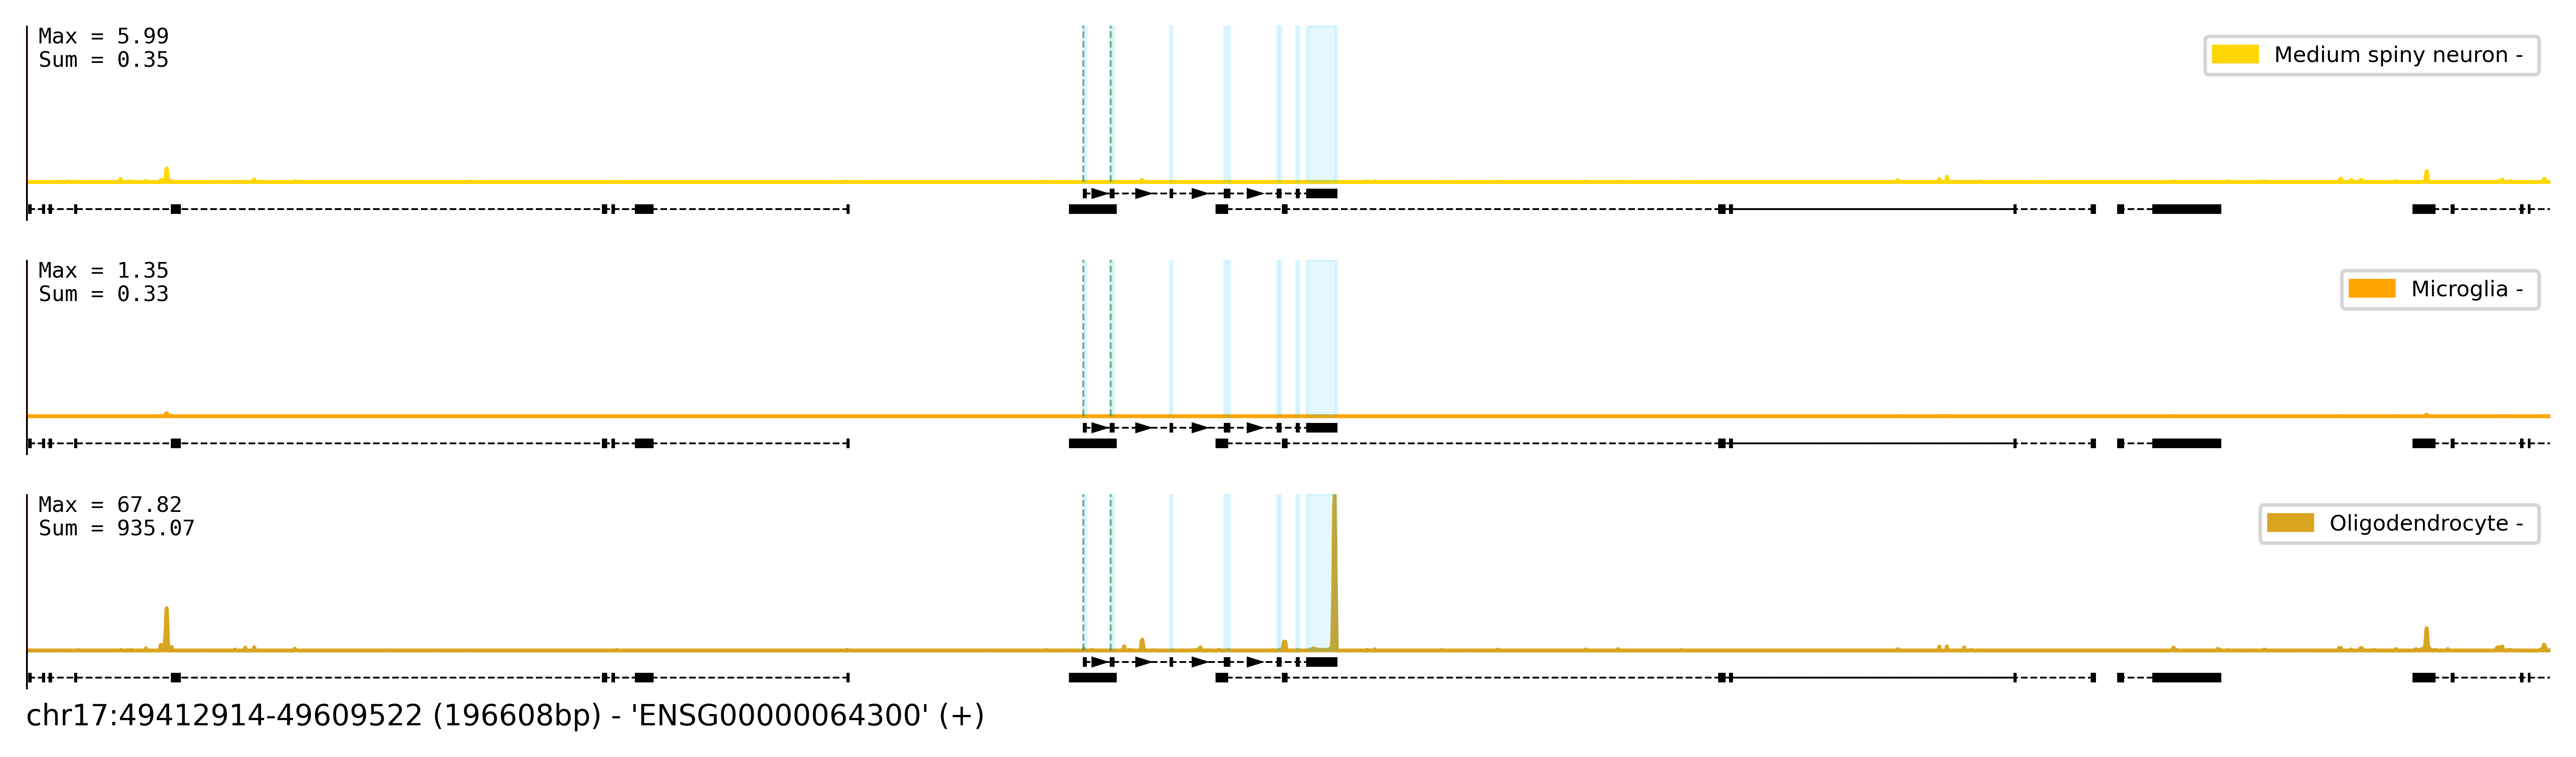

--- ISM Scores (Borzoi) ---


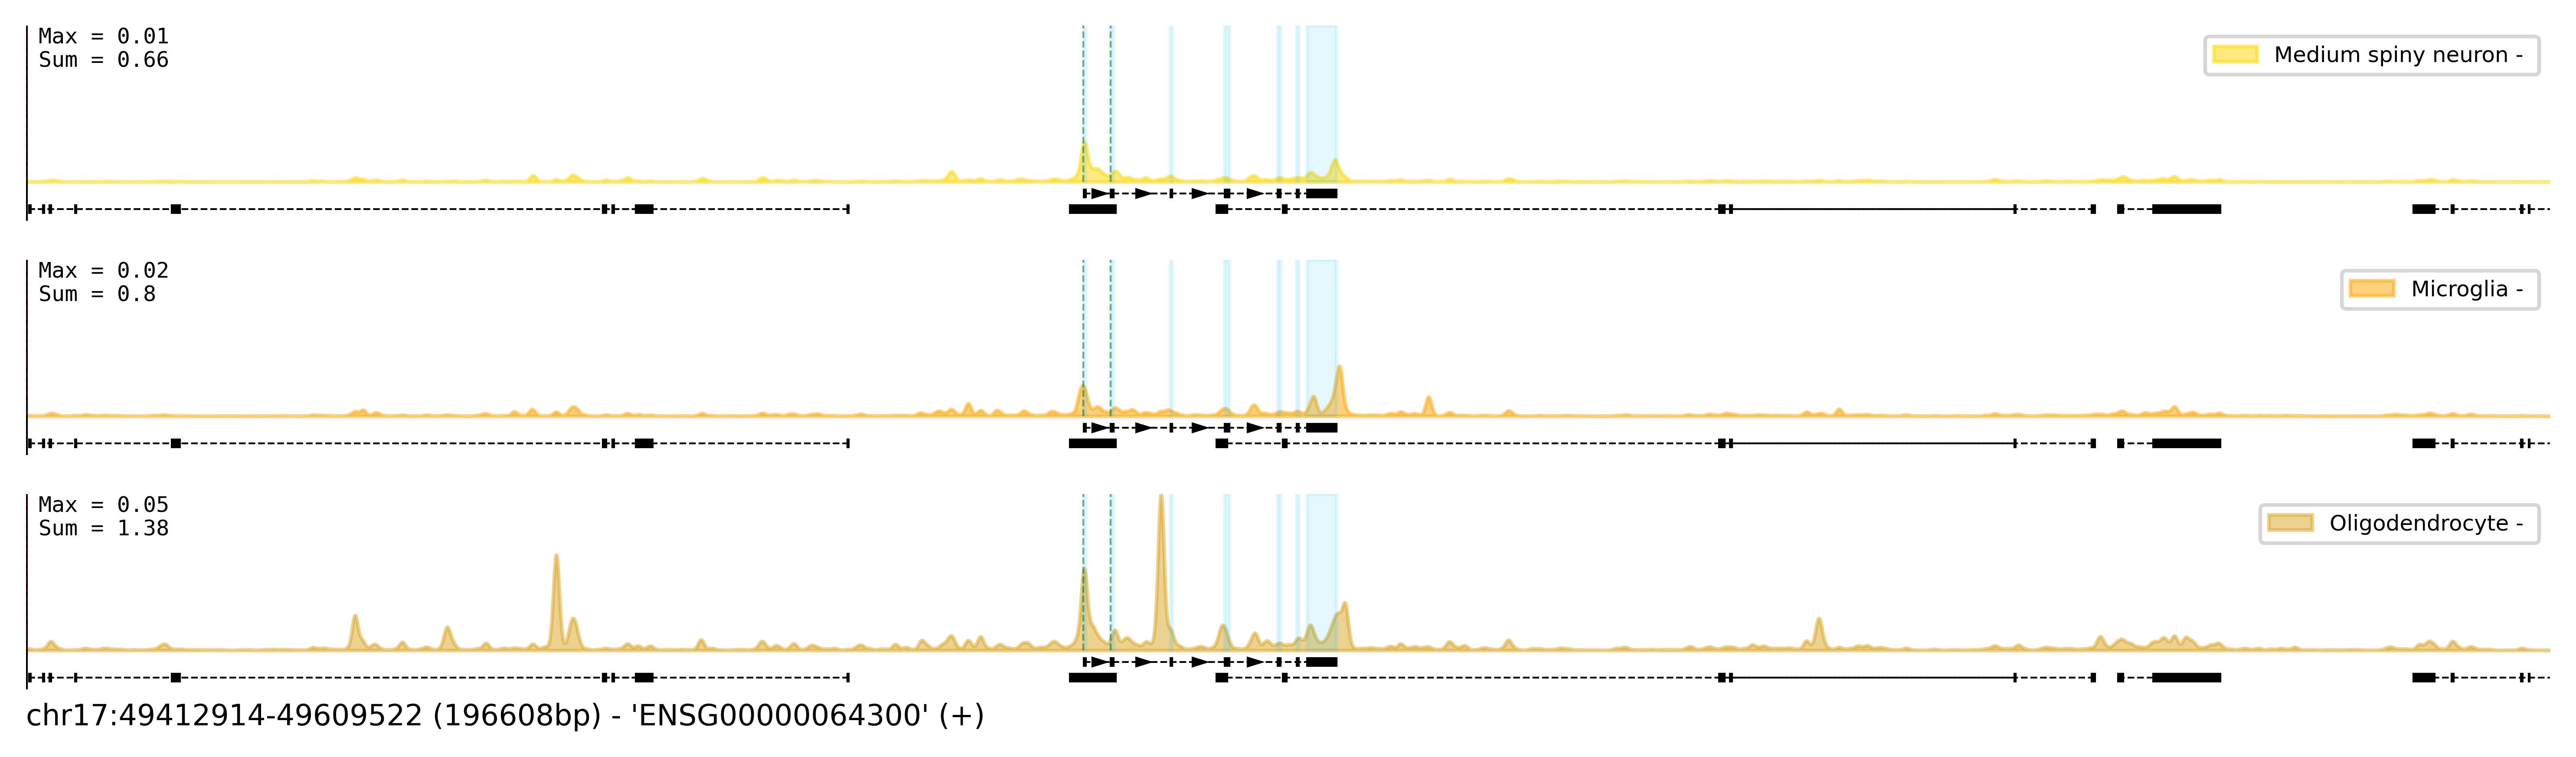

In [11]:
#Plot

save_figs = True
save_suffix = '_ENSG00000064300'

#Visualize coverage tracks
bin_size = 16
pad = 0
plot_start = 524288//2 - 98304
plot_end = 524288//2 + 98304

plot_measurements = True
plot_scores = True

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Medium spiny neuron.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Microglia.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Oligodendrocyte$')).values)[0].tolist(),
]

ism_indices = [
    [0],
    [1],
    [2],
]

track_names = [
    '',
    '',
    '',
]

track_files = [
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Medium spiny neuron.*')]['file'].values.tolist(),
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Microglia.*')]['file'].values.tolist(),
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Oligodendrocyte$')]['file'].values.tolist(),
]

track_colors = [
    ['gold'],
    ['orange'],
    ['goldenrod'],
]

track_labels = [
    ['Medium spiny neuron'],
    ['Microglia'],
    ['Oligodendrocyte'],
]

track_scale = 1.
track_transform = 3./4.
soft_clip = None

untransform_old = False

#Override apa annotations to indicate prediction window cutoff
apa_df_gene_utr = pd.DataFrame({
    'chrom' : [chrom, chrom],
    'gene' : [search_gene, search_gene],
    'strand' : [gene_strand, gene_strand],
    'position_hg38' : [start + 524288 // 2 - 98304, start + 524288 // 2 + 98304],
})

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    plot_pair=False,
    pair_order=[1, 0],
    pair_alpha=1.,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=True,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=untransform_old,
)

if plot_measurements :
    
    track_scale = 1.
    track_transform = 3./4.
    soft_clip = None
    
    y_meas = []
    track_indices_meas = []
    
    track_i = 0
    for cov_files in track_files :
        
        read_coverage_func, close_coverage_func = get_coverage_reader(cov_files, 32768, 0, "hg38/blacklist/blacklist_hg38_all.bed")
        cov_targets = read_coverage_func(chrom, start, end, clip_soft=soft_clip, clip=768., scale=track_scale, transform_old=False)
        close_coverage_func()
        
        y_meas.append(cov_targets[None, None, ...])
        
        track_index = []
        for j in range(len(cov_files)) :
            track_index.append(track_i)
            track_i += 1
        
        track_indices_meas.append(track_index)
    
    y_meas = np.concatenate(y_meas, axis=-1)
    
    print("--- Measured ---")

    #Plot coverage
    plot_coverage_tracks(
        y_meas,
        track_indices_meas,
        track_names,
        track_colors,
        track_labels,
        track_scale,
        track_transform,
        soft_clip,
        start,
        plot_pair=False,
        pair_order=[1, 0],
        pair_alpha=1.,
        log_scale=False,
        same_scale=True,
        plot_start_rel=plot_start,
        plot_end_rel=plot_end,
        highlight_covr_poses_rel=highlight_covr_poses_rel,
        covr_orientation=covr_orientation,
        covr_agg=covr_agg,
        covr_width=covr_width,
        bin_size=bin_size,
        pad=pad,
        save_figs=save_figs,
        save_suffix=save_suffix + '_meas',
        gene_slice=gene_slice,
        gene_slices=gene_slices,
        isoform_slices=isoform_slices,
        gene_strand=gene_strand,
        chrom=chrom,
        search_gene=search_gene,
        gene_strands=gene_strands,
        apa_df_gene_utr=apa_df_gene_utr,
        apa_df_gene_intron=apa_df_gene_intron,
        tss_df_gene=tss_df_gene,
        annotate_utr_apa=True,
        annotate_intron_apa=True,
        annotate_tss=True,
        plot_strands=True,
        plot_other_genes=True,
        plot_other_gene_strands=False,
        plot_isoforms=False,
        plot_isoform_strands=False,
        gene_color='black',
        isoform_color='dimgray',
        other_gene_color='black',
        max_isoforms=5,
        isoform_height_frac=0.,
        plot_as_bars=False,
        fig_size=(10, 1),
        untransform_old=untransform_old,
    )

if plot_scores :
    
    #ISM
    s_wt = pred_grad_wt.T[None, None, ...]
    
    #Average-pool and crop
    s_wt = np.mean(np.reshape(s_wt, (1, 1, s_wt.shape[2] // bin_size, bin_size, s_wt.shape[3])), axis=-2)
    if pad > 0 :
        s_wt = s_wt[..., pad:-pad, :]

    track_scale = 1.
    track_transform = 1.
    soft_clip = None

    print("--- ISM Scores (Borzoi) ---")

    #Plot coverage
    plot_coverage_tracks(
        s_wt,
        ism_indices,
        track_names,
        track_colors,
        track_labels,
        track_scale,
        track_transform,
        soft_clip,
        start,
        plot_pair=False,
        log_scale=False,
        same_scale=True,
        plot_start_rel=plot_start,
        plot_end_rel=plot_end,
        bin_size=bin_size,
        pad=pad,
        save_figs=save_figs,
        save_suffix=save_suffix + '_contrib',
        gene_slice=gene_slice,
        gene_slices=gene_slices,
        isoform_slices=[],
        gene_strand=gene_strand,
        chrom=chrom,
        search_gene=search_gene,
        gene_strands=[],
        apa_df_gene_utr=apa_df_gene_utr,
        apa_df_gene_intron=apa_df_gene_intron,
        tss_df_gene=tss_df_gene,
        annotate_utr_apa=True,
        annotate_intron_apa=True,
        annotate_tss=True,
        plot_strands=True,
        plot_other_genes=True,
        plot_other_gene_strands=False,
        plot_isoforms=False,
        plot_isoform_strands=False,
        gene_color='black',
        isoform_color='dimgray',
        other_gene_color='black',
        max_isoforms=5,
        isoform_height_frac=0.,
        plot_as_bars=False,
        fig_size=(10, 1),
        global_y_min=np.min(pred_grad_wt[:, plot_start:plot_end]),#0.,
    )


--- Measured ---


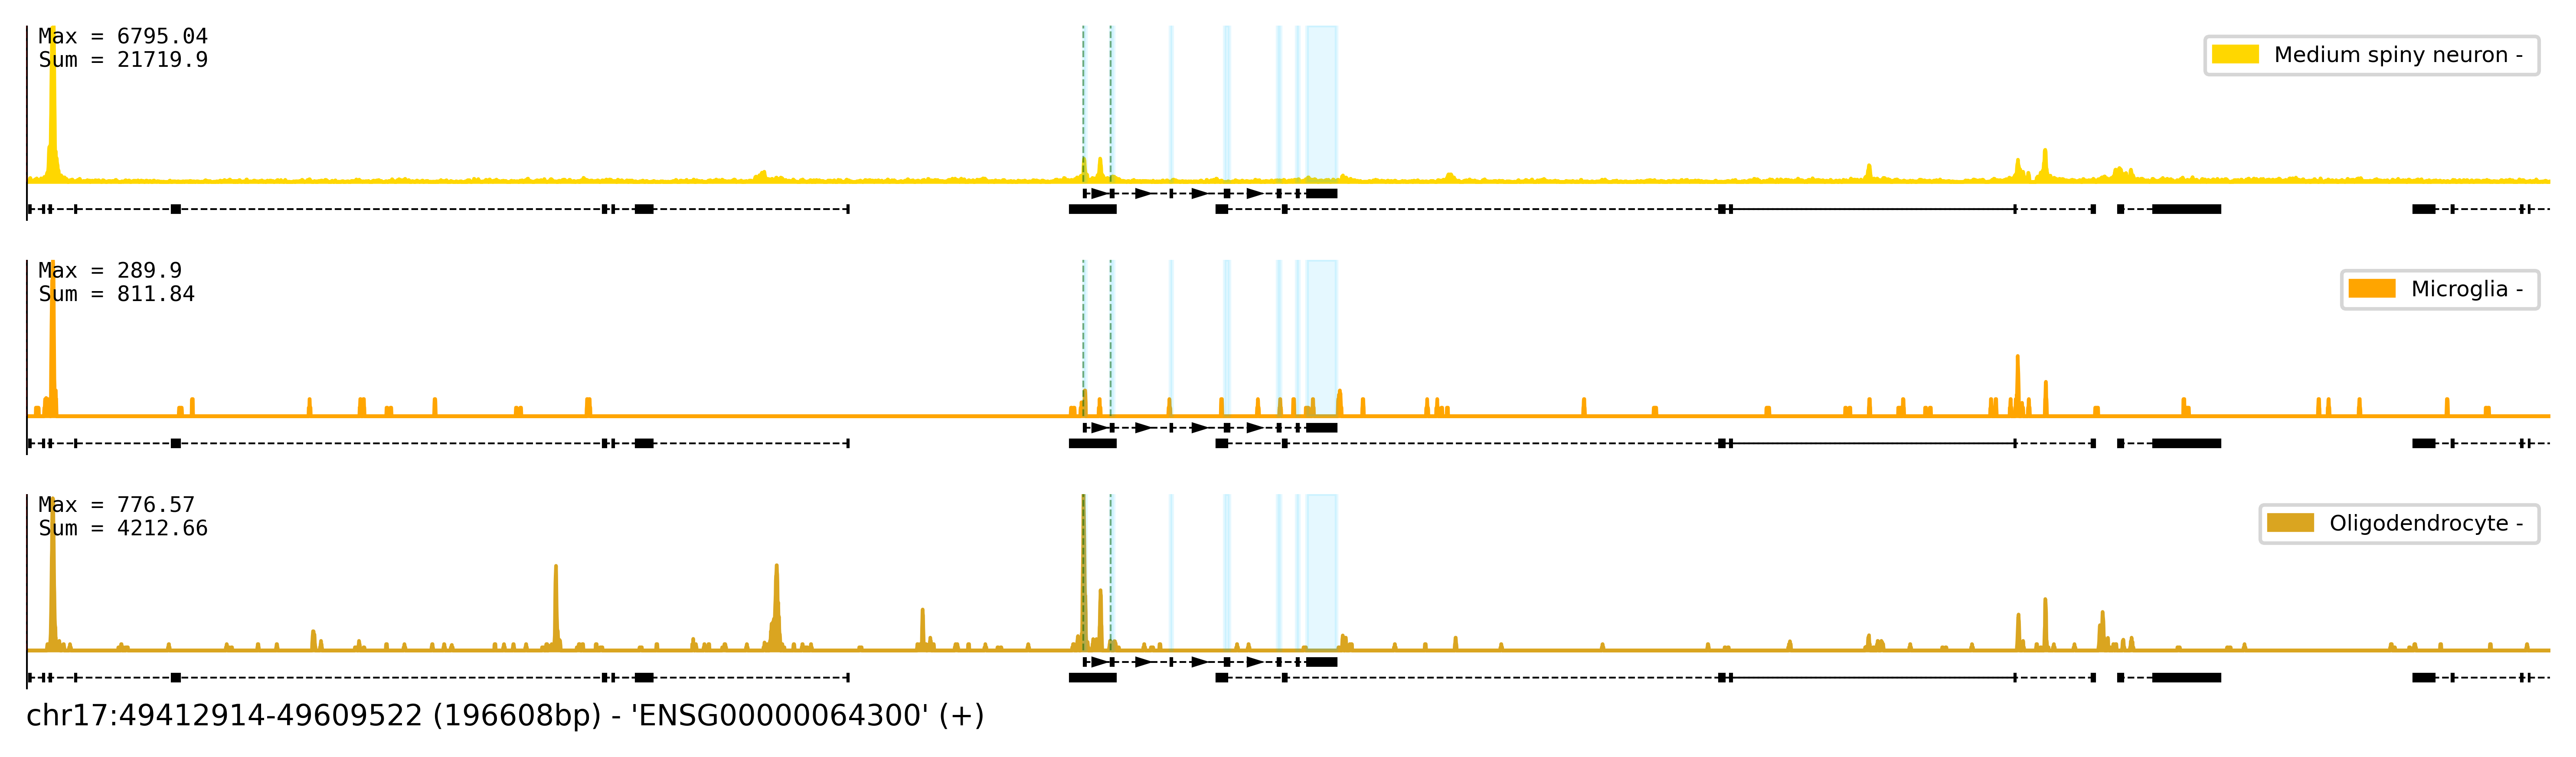

In [17]:
#Plot

save_figs = True
save_suffix = '_ENSG00000064300_accessibility'

#Visualize coverage tracks
bin_size = 16
pad = 0
plot_start = 524288//2 - 98304
plot_end = 524288//2 + 98304

plot_measurements = True

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_names = [
    '',
    '',
    '',
]

track_files = [
    ['/home/drk/tillage/datasets/human/atac/catlas/kai108/Fetal_Inhibitory_Neuron_1.w5'], #kai81/Fetal_Excitatory_Neuron_1.w5
    ['/home/drk/tillage/datasets/human/atac/catlas/kai182/Microglia.w5'],
    ['/home/drk/tillage/datasets/human/atac/catlas/kai188/Oligodendrocyte.w5'],
]

track_colors = [
    ['gold'],
    ['orange'],
    ['goldenrod'],
]

track_labels = [
    ['Medium spiny neuron'],
    ['Microglia'],
    ['Oligodendrocyte'],
]

untransform_old = False

#Override apa annotations to indicate prediction window cutoff
apa_df_gene_utr = pd.DataFrame({
    'chrom' : [chrom, chrom],
    'gene' : [search_gene, search_gene],
    'strand' : [gene_strand, gene_strand],
    'position_hg38' : [start + 524288 // 2 - 98304, start + 524288 // 2 + 98304],
})

#Plot coverage
if plot_measurements :
    
    track_scale = 1.
    track_transform = 3./4.
    soft_clip = None
    
    y_meas = []
    track_indices_meas = []
    
    track_i = 0
    for cov_files in track_files :
        
        read_coverage_func, close_coverage_func = get_coverage_reader(cov_files, 32768, 0, "hg38/blacklist/blacklist_hg38_all.bed")
        cov_targets = read_coverage_func(chrom, start, end, clip_soft=soft_clip, clip=768., scale=track_scale, transform_old=False)
        close_coverage_func()
        
        y_meas.append(cov_targets[None, None, ...])
        
        track_index = []
        for j in range(len(cov_files)) :
            track_index.append(track_i)
            track_i += 1
        
        track_indices_meas.append(track_index)
    
    y_meas = np.concatenate(y_meas, axis=-1)
    
    print("--- Measured ---")

    #Plot coverage
    plot_coverage_tracks(
        y_meas,
        track_indices_meas,
        track_names,
        track_colors,
        track_labels,
        track_scale,
        track_transform,
        soft_clip,
        start,
        plot_pair=False,
        pair_order=[1, 0],
        pair_alpha=1.,
        log_scale=False,
        same_scale=False,
        plot_start_rel=plot_start,
        plot_end_rel=plot_end,
        highlight_covr_poses_rel=highlight_covr_poses_rel,
        covr_orientation=covr_orientation,
        covr_agg=covr_agg,
        covr_width=covr_width,
        bin_size=bin_size,
        pad=pad,
        save_figs=save_figs,
        save_suffix=save_suffix + '_meas',
        gene_slice=gene_slice,
        gene_slices=gene_slices,
        isoform_slices=isoform_slices,
        gene_strand=gene_strand,
        chrom=chrom,
        search_gene=search_gene,
        gene_strands=gene_strands,
        apa_df_gene_utr=apa_df_gene_utr,
        apa_df_gene_intron=apa_df_gene_intron,
        tss_df_gene=tss_df_gene,
        annotate_utr_apa=True,
        annotate_intron_apa=True,
        annotate_tss=True,
        plot_strands=True,
        plot_other_genes=True,
        plot_other_gene_strands=False,
        plot_isoforms=False,
        plot_isoform_strands=False,
        gene_color='black',
        isoform_color='dimgray',
        other_gene_color='black',
        max_isoforms=5,
        isoform_height_frac=0.,
        plot_as_bars=False,
        fig_size=(10, 1),
        untransform_old=untransform_old,
    )


In [12]:
#Randomly shuffle putative enhancer

shuffle_pos = 49501320

shuffle_width = 2048
dinuc_shuffle = True
n_samples = 32

y_muts = []
for sample_ix in range(n_samples) :
    
    print("sample_ix = " + str(sample_ix))
    
    #Get mut sequence
    sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

    if not dinuc_shuffle :
        #Zero sequence
        sequence_one_hot_mut[shuffle_pos - start - shuffle_width//2:shuffle_pos - start + shuffle_width//2, :] = 0.
        
        #Get nucleotide frequencies
        nt_freq = np.sum(sequence_one_hot_wt[shuffle_pos - start - shuffle_width//2:shuffle_pos - start + shuffle_width//2, :], axis=0)
        nt_freq /= np.sum(nt_freq)
        
        #Get random substitution
        rand_ind = np.random.choice([0, 1, 2, 3], size=(shuffle_width,), p=nt_freq)
        pos_ind = np.arange(shuffle_width, dtype='int32') + shuffle_pos - start - shuffle_width//2
        
        sequence_one_hot_mut[pos_ind, rand_ind] = 1.
    else :
        print("(dinuc)")
        
        #Zero sequence
        sequence_one_hot_mut[shuffle_pos - start - shuffle_width//2:shuffle_pos - start + shuffle_width//2, :] = 0.
        
        pos_ind = np.arange(shuffle_width, dtype='int32') + shuffle_pos - start - shuffle_width//2
        
        shuffled_pos_ind = [
            [pos_ind[pos_j], pos_ind[pos_j + 1]]
            if pos_j + 1 < pos_ind.shape[0] else [pos_ind[pos_j]]
            for pos_j in range(0, pos_ind.shape[0], 2)
        ]

        shuffled_shuffle_index = np.arange(len(shuffled_pos_ind), dtype="int32")
        np.random.shuffle(shuffled_shuffle_index)

        shuffled_pos_ind_new = []
        for pos_tuple_i in range(len(shuffled_pos_ind)):
            shuffled_pos_ind_new.extend(
                shuffled_pos_ind[shuffled_shuffle_index[pos_tuple_i]]
            )

        shuffled_pos_ind = np.array(shuffled_pos_ind_new, dtype="int32")
        sequence_one_hot_mut[shuffled_pos_ind, :] = sequence_one_hot_wt[pos_ind, :]

    #Make mut prediction
    y_mut = predict_tracks(models, sequence_one_hot_mut)
    y_muts.append(y_mut[None, :])

y_mut = np.mean(np.concatenate(y_muts, axis=0), axis=0)

print("y_mut.shape = " + str(y_mut.shape))


sample_ix = 0
(dinuc)
sample_ix = 1
(dinuc)
sample_ix = 2
(dinuc)
sample_ix = 3
(dinuc)
sample_ix = 4
(dinuc)
sample_ix = 5
(dinuc)
sample_ix = 6
(dinuc)
sample_ix = 7
(dinuc)
sample_ix = 8
(dinuc)
sample_ix = 9
(dinuc)
sample_ix = 10
(dinuc)
sample_ix = 11
(dinuc)
sample_ix = 12
(dinuc)
sample_ix = 13
(dinuc)
sample_ix = 14
(dinuc)
sample_ix = 15
(dinuc)
sample_ix = 16
(dinuc)
sample_ix = 17
(dinuc)
sample_ix = 18
(dinuc)
sample_ix = 19
(dinuc)
sample_ix = 20
(dinuc)
sample_ix = 21
(dinuc)
sample_ix = 22
(dinuc)
sample_ix = 23
(dinuc)
sample_ix = 24
(dinuc)
sample_ix = 25
(dinuc)
sample_ix = 26
(dinuc)
sample_ix = 27
(dinuc)
sample_ix = 28
(dinuc)
sample_ix = 29
(dinuc)
sample_ix = 30
(dinuc)
sample_ix = 31
(dinuc)
y_mut.shape = (1, 4, 32768, 1702)


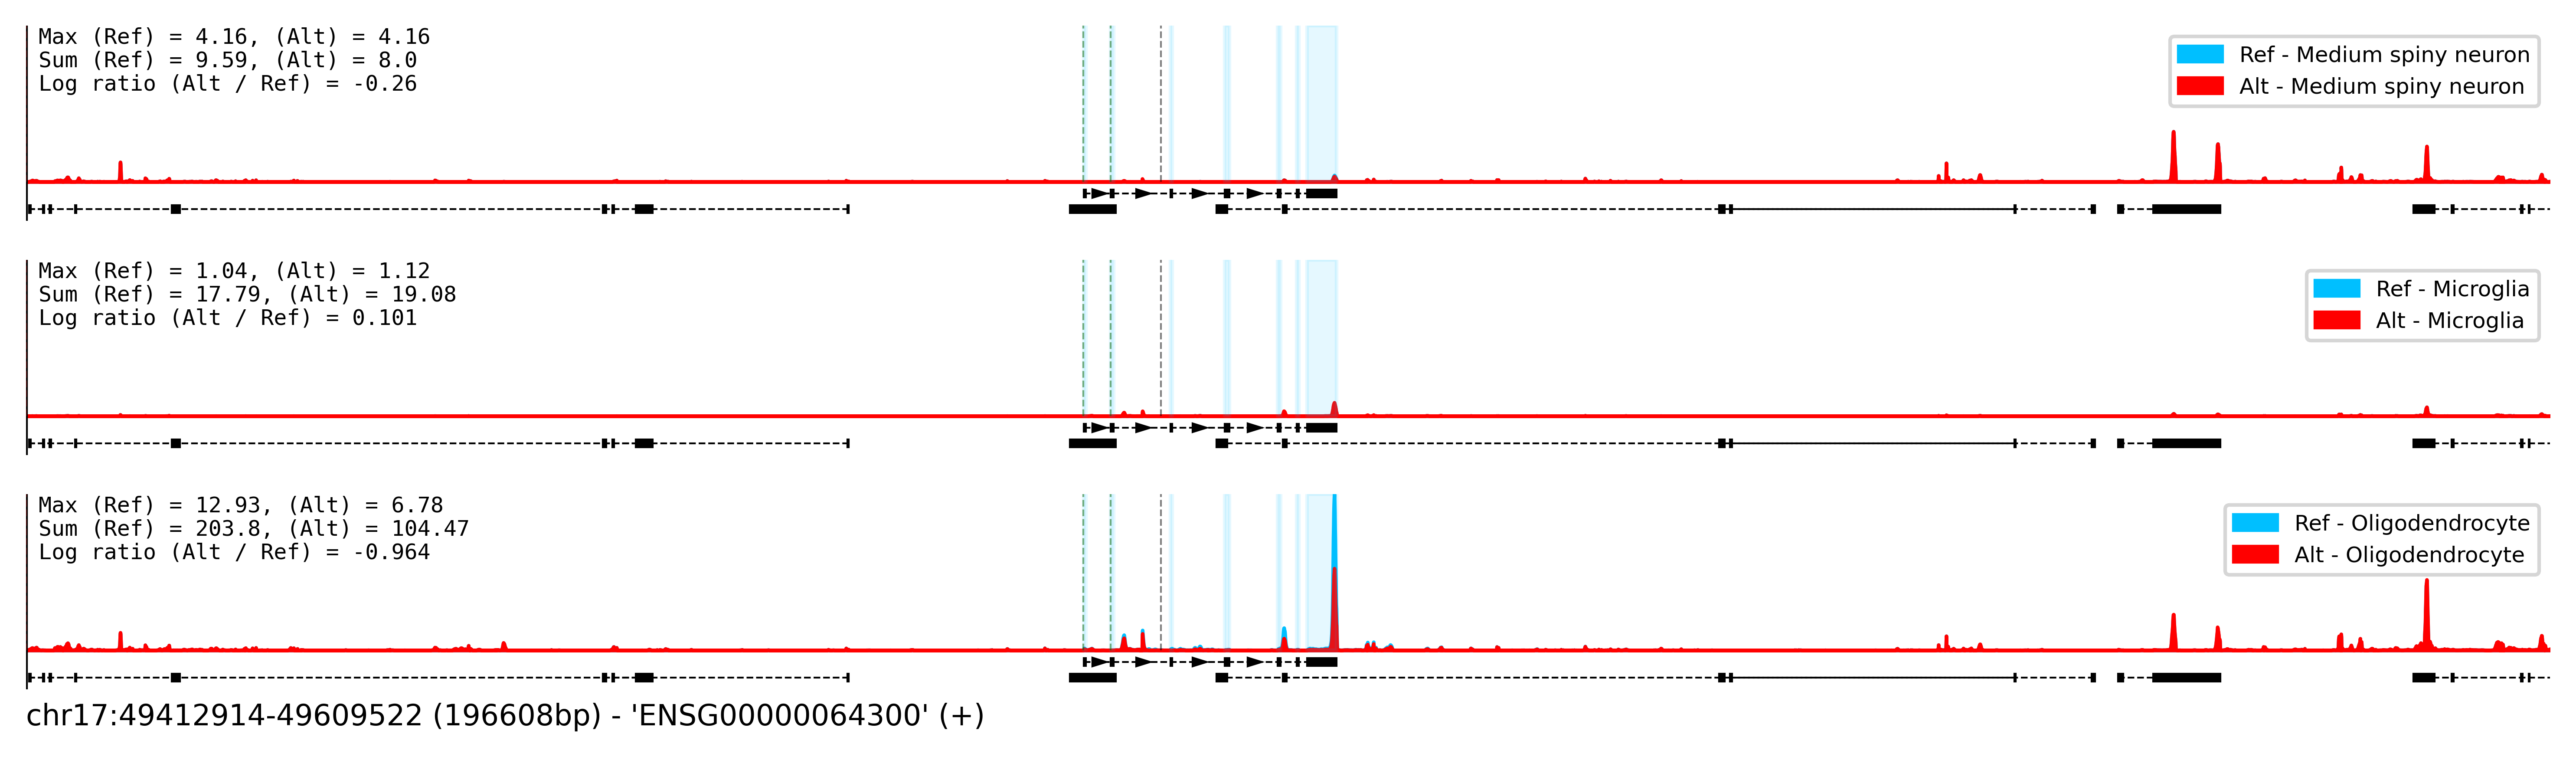

In [13]:
#Plot

save_figs = True
save_suffix = '_ENSG00000064300_dinuc_shuffle'

#Visualize coverage tracks
bin_size = 16
pad = 0
plot_start = 524288//2 - 98304
plot_end = 524288//2 + 98304

highlight_pos_rel = shuffle_pos - start

plot_measurements = True
plot_scores = True

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Medium spiny neuron.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Microglia.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Oligodendrocyte$')).values)[0].tolist(),
]

ism_indices = [
    [0],
    [1],
    [2],
]

track_names = [
    'Medium spiny neuron',
    'Microglia',
    'Oligodendrocyte',
]

track_files = [
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Medium spiny neuron.*')]['file'].values.tolist(),
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Microglia.*')]['file'].values.tolist(),
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Oligodendrocyte$')]['file'].values.tolist(),
]

track_colors = [
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
]

track_labels = [
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
]

track_scale = 1.
track_transform = 3./4.
soft_clip = None

untransform_old = False

#Override apa annotations to indicate prediction window cutoff
apa_df_gene_utr = pd.DataFrame({
    'chrom' : [chrom, chrom],
    'gene' : [search_gene, search_gene],
    'strand' : [gene_strand, gene_strand],
    'position_hg38' : [start + 524288 // 2 - 98304, start + 524288 // 2 + 98304],
})

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    pair_order=[0, 1],
    pair_alpha=1.,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    highlight_pos_rel=highlight_pos_rel,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=True,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=untransform_old,
)


In [14]:
#Randomly shuffle putative enhancer (2)

shuffle_pos = 49454194

shuffle_width = 2048
dinuc_shuffle = True
n_samples = 32

y_muts = []
for sample_ix in range(n_samples) :
    
    print("sample_ix = " + str(sample_ix))
    
    #Get mut sequence
    sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

    if not dinuc_shuffle :
        #Zero sequence
        sequence_one_hot_mut[shuffle_pos - start - shuffle_width//2:shuffle_pos - start + shuffle_width//2, :] = 0.
        
        #Get nucleotide frequencies
        nt_freq = np.sum(sequence_one_hot_wt[shuffle_pos - start - shuffle_width//2:shuffle_pos - start + shuffle_width//2, :], axis=0)
        nt_freq /= np.sum(nt_freq)
        
        #Get random substitution
        rand_ind = np.random.choice([0, 1, 2, 3], size=(shuffle_width,), p=nt_freq)
        pos_ind = np.arange(shuffle_width, dtype='int32') + shuffle_pos - start - shuffle_width//2
        
        sequence_one_hot_mut[pos_ind, rand_ind] = 1.
    else :
        print("(dinuc)")
        
        #Zero sequence
        sequence_one_hot_mut[shuffle_pos - start - shuffle_width//2:shuffle_pos - start + shuffle_width//2, :] = 0.
        
        pos_ind = np.arange(shuffle_width, dtype='int32') + shuffle_pos - start - shuffle_width//2
        
        shuffled_pos_ind = [
            [pos_ind[pos_j], pos_ind[pos_j + 1]]
            if pos_j + 1 < pos_ind.shape[0] else [pos_ind[pos_j]]
            for pos_j in range(0, pos_ind.shape[0], 2)
        ]

        shuffled_shuffle_index = np.arange(len(shuffled_pos_ind), dtype="int32")
        np.random.shuffle(shuffled_shuffle_index)

        shuffled_pos_ind_new = []
        for pos_tuple_i in range(len(shuffled_pos_ind)):
            shuffled_pos_ind_new.extend(
                shuffled_pos_ind[shuffled_shuffle_index[pos_tuple_i]]
            )

        shuffled_pos_ind = np.array(shuffled_pos_ind_new, dtype="int32")
        sequence_one_hot_mut[shuffled_pos_ind, :] = sequence_one_hot_wt[pos_ind, :]

    #Make mut prediction
    y_mut = predict_tracks(models, sequence_one_hot_mut)
    y_muts.append(y_mut[None, :])

y_mut = np.mean(np.concatenate(y_muts, axis=0), axis=0)

print("y_mut.shape = " + str(y_mut.shape))


sample_ix = 0
(dinuc)
sample_ix = 1
(dinuc)
sample_ix = 2
(dinuc)
sample_ix = 3
(dinuc)
sample_ix = 4
(dinuc)
sample_ix = 5
(dinuc)
sample_ix = 6
(dinuc)
sample_ix = 7
(dinuc)
sample_ix = 8
(dinuc)
sample_ix = 9
(dinuc)
sample_ix = 10
(dinuc)
sample_ix = 11
(dinuc)
sample_ix = 12
(dinuc)
sample_ix = 13
(dinuc)
sample_ix = 14
(dinuc)
sample_ix = 15
(dinuc)
sample_ix = 16
(dinuc)
sample_ix = 17
(dinuc)
sample_ix = 18
(dinuc)
sample_ix = 19
(dinuc)
sample_ix = 20
(dinuc)
sample_ix = 21
(dinuc)
sample_ix = 22
(dinuc)
sample_ix = 23
(dinuc)
sample_ix = 24
(dinuc)
sample_ix = 25
(dinuc)
sample_ix = 26
(dinuc)
sample_ix = 27
(dinuc)
sample_ix = 28
(dinuc)
sample_ix = 29
(dinuc)
sample_ix = 30
(dinuc)
sample_ix = 31
(dinuc)
y_mut.shape = (1, 4, 32768, 1702)


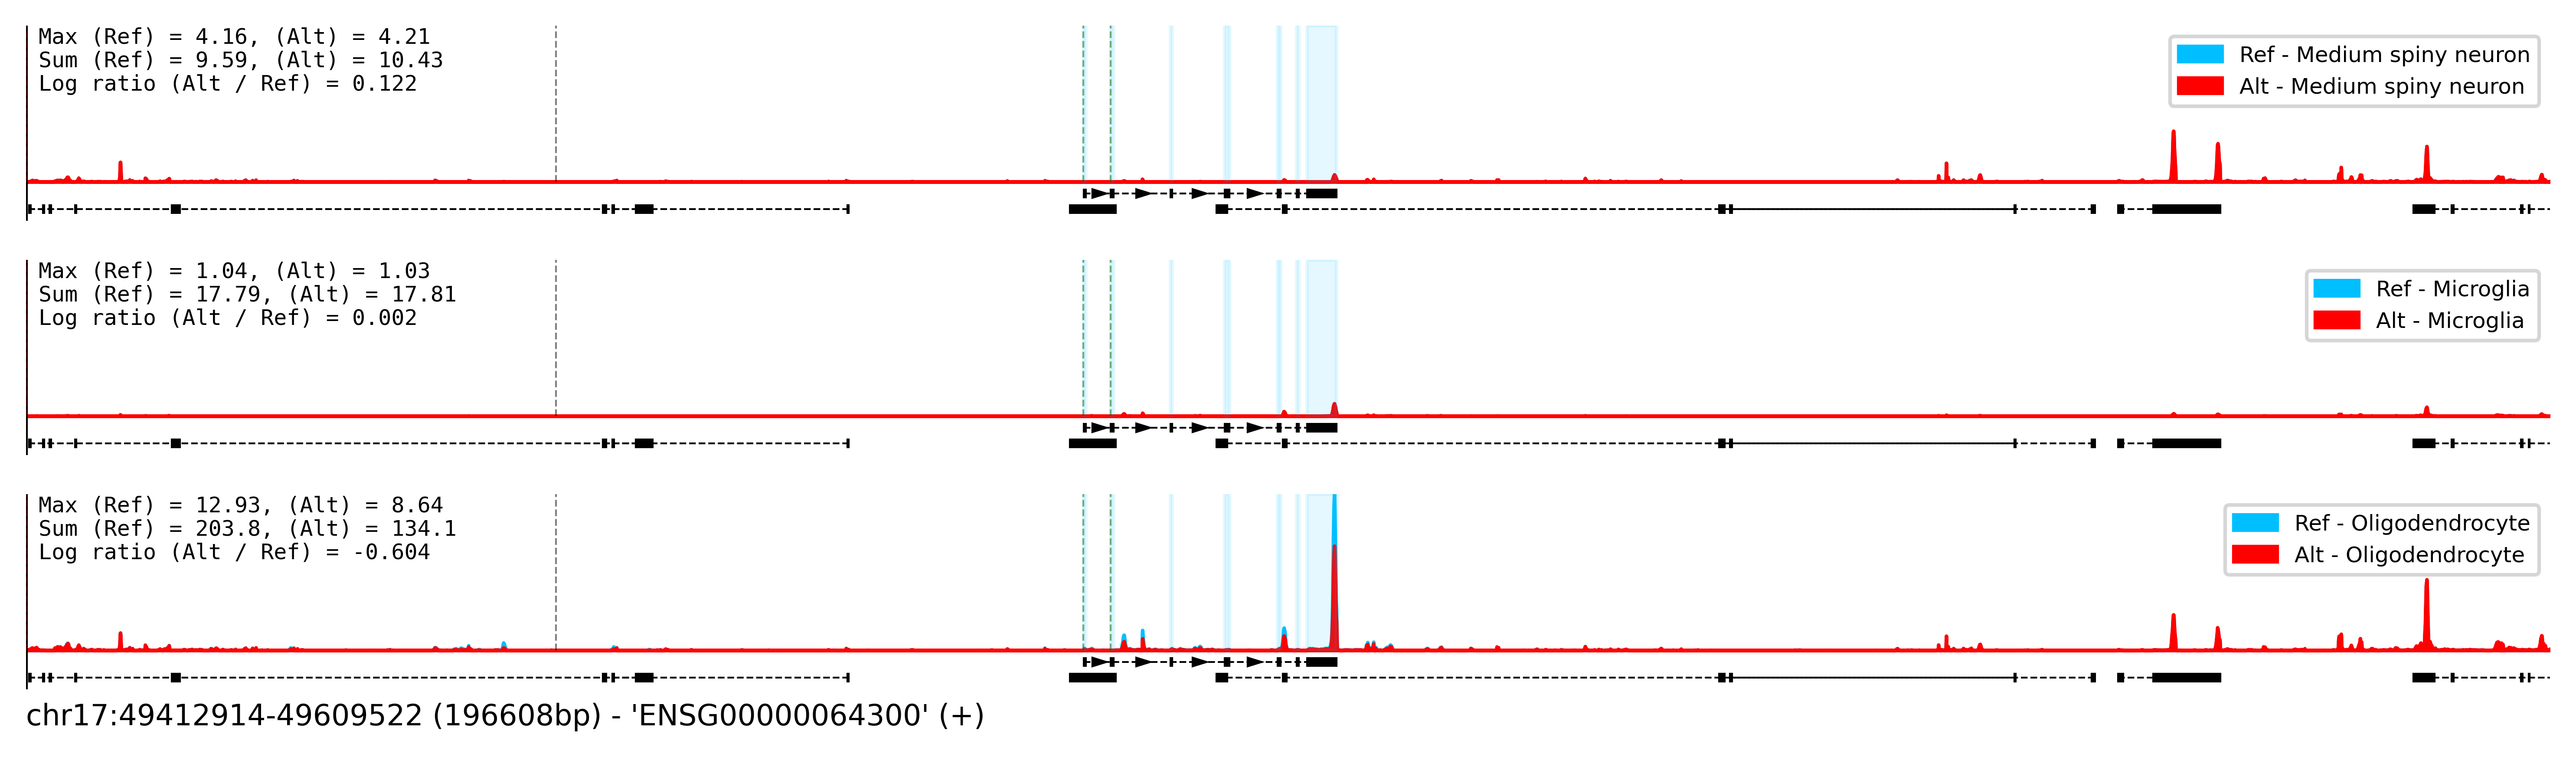

In [15]:
#Plot

save_figs = True
save_suffix = '_ENSG00000064300_dinuc_shuffle_2'

#Visualize coverage tracks
bin_size = 16
pad = 0
plot_start = 524288//2 - 98304
plot_end = 524288//2 + 98304

highlight_pos_rel = shuffle_pos - start

plot_measurements = True
plot_scores = True

highlight_covr_poses_rel = None
covr_orientation = 'before'
covr_agg = 'mean'
covr_width = 15

#Tracks
track_indices = [
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Medium spiny neuron.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Microglia.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Oligodendrocyte$')).values)[0].tolist(),
]

ism_indices = [
    [0],
    [1],
    [2],
]

track_names = [
    'Medium spiny neuron',
    'Microglia',
    'Oligodendrocyte',
]

track_files = [
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Medium spiny neuron.*')]['file'].values.tolist(),
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Microglia.*')]['file'].values.tolist(),
    targets_df.loc[targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Oligodendrocyte$')]['file'].values.tolist(),
]

track_colors = [
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
]

track_labels = [
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
]

track_scale = 1.
track_transform = 3./4.
soft_clip = None

untransform_old = False

#Override apa annotations to indicate prediction window cutoff
apa_df_gene_utr = pd.DataFrame({
    'chrom' : [chrom, chrom],
    'gene' : [search_gene, search_gene],
    'strand' : [gene_strand, gene_strand],
    'position_hg38' : [start + 524288 // 2 - 98304, start + 524288 // 2 + 98304],
})

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    pair_order=[0, 1],
    pair_alpha=1.,
    log_scale=False,
    same_scale=True,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    highlight_pos_rel=highlight_pos_rel,
    highlight_covr_poses_rel=highlight_covr_poses_rel,
    covr_orientation=covr_orientation,
    covr_agg=covr_agg,
    covr_width=covr_width,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix + '_pred',
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=True,
    annotate_intron_apa=True,
    annotate_tss=True,
    plot_strands=True,
    plot_other_genes=True,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1),
    untransform_old=untransform_old,
)
